# ECE 311 Lab 2: LSI Systems
## Due Date: 9/18 @ 11:59PM on Canvas
In this lab, we will explore Linear Shift-Invariant (LSI) systems and their properties with applications involving toy signals, image filtering, stock data, and even an example of a simple non-linear system. Let's get started!

In [5]:
# import necessary libraries for this lab
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

from skimage.io import imread

%matplotlib inline

## Getting Started with Convolution

We remember from ECE 210, that convolution describes how any continuous-time input signal is processed by an LTI system. Given an input $x(t)$ and an LTI system's impulse response $h(t)$, the system output $y(t)$ is given by

$$
y(t) = x(t) * h(t).
$$

Recall that convolution for continous-time signals is defined as

$$
y(t) = \int_{\tau = -\infty}^{\infty}x(\tau)h(t-\tau)d\tau = \int_{\tau=-\infty}^{\infty}x(t-\tau)h(\tau)d\tau.
$$

You have learned in ECE 310 that discrete-time LTI systems also have an impulse response $h[n]$, which is the system response to a unit Kronecker delta $\delta[n]$ input. Thus, we can express the system output given an input signal via discrete-time convolution.

$$
y[n] = x[n] * h[n]
$$

$$
y[n] = \sum_{k=-\infty}^{\infty}x[k]h[n-k] = \sum_{k=-\infty}^{\infty}x[n-k]h[k]
$$

Like the width properties of continuous-time convolution, if $x$ is of length $N$ and $h$ is of length $M$, the result $y$ will be of length $N+M-1$. It is important to note that every LTI system can be represented by a convolution, every system that can be expressed as a convolution is fully described by its impulse response, and any system fully described by its impulse response must be LTI. This means the relationship between LTI systems, convolution, and impulse responses is an "if and only if" relationship; they all imply one another! This is something handy to keep in mind whenever you want to identify and describe an LTI system.

The key function we will use to perform convolutions is the $\textrm{convolve()}$ function in the $\textrm{scipy.signal}$ module. The usage of this function for an example system is as follows:

$$
x[n] = \delta[n]+2\delta[n-2]+3\delta[n-4]
$$

$$
y[n] = x[n]+3x[n-1]
$$

In [6]:
x = np.array([1, 0, 2, 0, 3]) # input signal
h = np.array([1, 3]) # filter/system's impulse response
y = signal.convolve(x,h) # signal.convolve(in1,in2)

print(y) # verify this result by hand!

[1 3 2 6 3 9]


Note how we extracted the system's impulse response for the system's Linear Constant Coefficient Difference Equation (LCCDE): we simply replace each $x[n-k]$ with $\delta[n-k]$! This is equivalent to passing $\delta[n]$ as our input signal. Above, our first term takes the present input value and multiplies it by one, and the second term multiplies the most recent input by three. Intuitively, when we flip and shift our filter $h$ for the convolution, we will be applying this system to the input signal at each shift step. The $\textrm{signal.convolve()}$ function assumes the arrays that represent our signals begin at index zero.

# Exercise 1: Implementing LTI Systems

In the below code cell, implement the following LTI systems and plot the system response (using $\textrm{plt.stem()}$) to each of the listed input signals. Comment on the results in the following Markdown cell, i.e. compare and contrast how each system seems to affect each input signal. Remember to use the LCCDE for each system to infer its impulse response!

* System A: $y_a[n] = x[n]-x[n-1]$


* System B: $y_b[n] = \frac{1}{3}x[n]+\frac{1}{3}x[n-1]+\frac{1}{3}x[n-2]$



* $x_1[n] = u[n] - u[n-10], 0\leq n< 20$


* $x_2[n] = \sin\left(\frac{\pi}{20}n\right), 0\leq n< 40$

<StemContainer object of 3 artists>

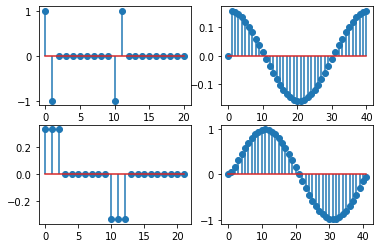

In [15]:
# create input signals here:
# Hint: Use np.sin and np.pi!

x1 = np.array(np.zeros(20))
x1[0] = 1
x1[10] = -1

x2 = np.array([np.sin((np.pi/20)*i) for i in range(40)])

# System A
sys_a = np.array([1,-1])

# plot result for x1
x1a_result = signal.convolve(x1,sys_a)

plt.figure()
plt.subplot(221)
plt.stem(x1a_result)

# plot result for x2
x2a_result = signal.convolve(x2,sys_a)

plt.subplot(222)
plt.stem(x2a_result)

# System B
sys_b = np.array([1/3,1/3,1/3])

# plot result for x1
x1b_result = signal.convolve(x1,sys_b)


plt.subplot(223)
plt.stem(x1b_result)

# plot result for x2
x2b_result = signal.convolve(x2,sys_b)

plt.subplot(224)
plt.stem(x2b_result)

## Comments here:

(Consider how each system affects the flatter and faster-changing parts of the input signals. What do you think each system is doing?)

 They key differnce between the two systems that I can notice is the change in from a consistant 1/3 signal that provides symetrical results and keep the output constant. However, with signal A it is differnt at the changing points where it is now mirrored at the changing points. 


# Exercise 2: Bitcoin Pricing Correction

One type of signal could be some non-physical 1D information. An example of this would be stock price or cryptocurrency price data. This data is notoriously noisy and can jump around unpredictably.

Remember that the systems we work with can be either causal or non-causal. A causal system only uses present and past information or values to calculate its present values, while a non-causal system can leverage future information. In this exercise, we will compare causal and non-causal versions of a system to smooth a day's worth of bitcoin price data. We have provided 24 hours of prices with pricing updates every minute (1440 points). The date in question is Christmas Eve Day (12/24), 2017.

Text(0, 0.5, 'Price (USD)')

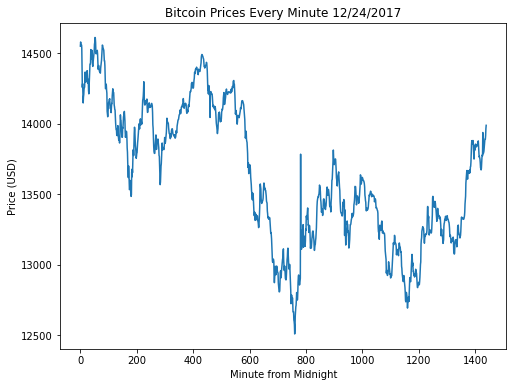

In [16]:
bitcoin_data = np.load('bitcoin-christmas.npy', allow_pickle=True)
n_points = len(bitcoin_data)
plt.figure(figsize = (8,6))
plt.plot(range(n_points), bitcoin_data)
plt.title('Bitcoin Prices Every Minute 12/24/2017')
plt.xlabel('Minute from Midnight')
plt.ylabel('Price (USD)')

Pretty noisy, right? Maybe a lot of last-minute Christmas gifts made the price even more unpredictable!

In this exercise, you will implement two length-51 moving average filters on this Bitcoin price data. The first will be causal and the second will be non-causal. Mathematically, we can represent these systems as follows:

$$
y_1[n] = \frac{1}{51}\sum_{i=0}^{50}x[n - i]
$$

$$
y_2[n] = \frac{1}{51}\sum_{i=-25}^{25}x[n - i]
$$

Furthermore, since the moving average filter is an LTI system we may implement it as a convolution using its impulse response. If you are having trouble seeing this, we suggest considering a length-5 moving average filter and "unrolling" the sum to understand that system definition and its impulse response.

Notice that the non-causal filter will require us to access negative indices according to the impulse response of our filter. A natural question to ask is how does the $\textrm{signal.convolve()}$ function perform non-causal convolution? How can you indicate negative indices when making an array for a system's impulse response? This is where the "same" mode comes in! We may use the "same" mode as follows:

```
y = signal.convolve(x, h, 'same'),
```

where $x$ is of length $N$ and $h$ is length $M$. This line of code will first perform regular convolution like the default mode where the first sample of each sequence is assumed to be at $n=0$. Then, it will only keep the center $N$ values (length of first argument/array). This operation is equivalent to zero-centering the second argument/array (```h``` in the above example). You may want to try a couple small examples to convince yourself this is true. The "same" mode will be important to keep in mind throughout this lab and the rest of the course.

**Important Note:** For the following two parts, we have provided the appropriate start and end indices to help us make sure each implementation returns results of the same size and to remove initial condition worries (ramping behavior since we would have fewer than 51 samples as the filter has partial overlap). **Please follow the plotting instructions in the following parts carefully!**

a. Construct the causal filter and apply it to the provided bitcoin price data (apply your causal system to the data in the ``bitcoin_data`` variable). To make sure your output is the same length and matches up correctly in time, please slice the result of convolving ``bitcoin_data`` with your causal filter using ``start`` and ``end``. Note that we do this to create the ``plotting_data`` variable. Plot the original data (``plotting_data``) and your smoothed data on the same plot. **Don't forget to include a legend!**

b. Construct the non-causal filter and apply it to the provided bitcoin price data (``bitcoin_data`` variable). Perform the same ``start`` and ``end`` slicing on your result as in part (a). Plot the original data (``plotting_data``) and your smoothed data on the same plot.

c. Plot the difference signals for each filter on the same plot. Let the difference signal for a system's output be given by

$$
y_d = y - \hat{y},
$$

where $\hat{y}$ is your system output and $y$ is the sliced original data used for plotting, ``plotting_data``.

d. Comment on the results in the following Markdown cell. What is noticeably different between the two sets of smoothed results from the causal and non-causal systems? Is it helpful to know a lot of past information or a decent amount of past and future information?

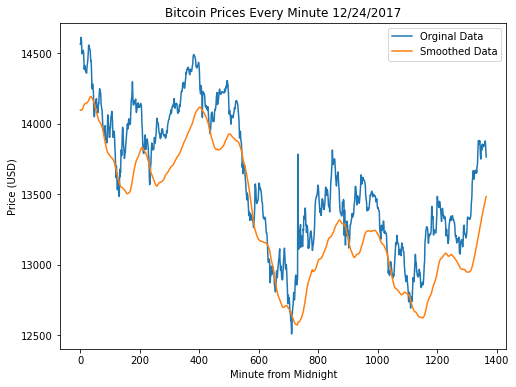

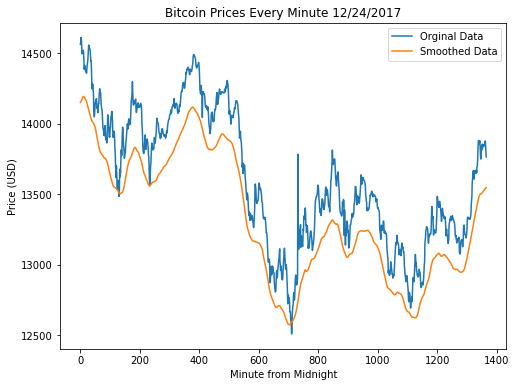

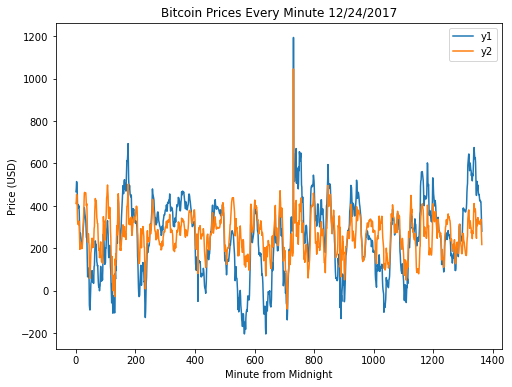

In [37]:
# Provided code
L = 51
half_L = 25
start = 50
end = len(bitcoin_data)-half_L
plotting_data = bitcoin_data[start:end] # plot against this data in parts a/b, pay attention to how we slice
result_length = len(plotting_data)

# Code for 2.a here, don't forget to plot original and filtered signals on same plot!

y1 = np.array([1/51 for i in range(50)])

out = signal.convolve(bitcoin_data, y1)
out_sliced = out[start:end]


plt.figure(figsize = (8,6))
plt.plot(range(len(plotting_data)), plotting_data, label = 'Orginal Data')
plt.plot(range(len(out_sliced)), out_sliced, label = 'Smoothed Data')
plt.title('Bitcoin Prices Every Minute 12/24/2017')
plt.xlabel('Minute from Midnight')
plt.ylabel('Price (USD)')
plt.legend()

# Code for 2.b here
        
non_causal = signal.convolve(bitcoin_data, y1, 'same')
non_causal_sliced = non_causal[start:end]

plt.figure(figsize = (8,6))
plt.plot(range(len(plotting_data)), plotting_data, label = 'Orginal Data')
plt.plot(range(len(non_causal_sliced)), non_causal_sliced, label = 'Smoothed Data')
plt.title('Bitcoin Prices Every Minute 12/24/2017')
plt.xlabel('Minute from Midnight')
plt.ylabel('Price (USD)')
plt.legend()
    
# Code for 2.c here

plt.figure(figsize = (8,6))
plt.plot(range(len(plotting_data)), plotting_data - out_sliced, label = 'y1')
plt.plot(range(len(non_causal_sliced)), plotting_data - non_causal_sliced, label = 'y2')
plt.title('Bitcoin Prices Every Minute 12/24/2017')
plt.xlabel('Minute from Midnight')
plt.ylabel('Price (USD)')
plt.legend()



## Comments for here:

Part 2(d):

There is definitly a difference in the signals as when you include both past and future data points you are more accuratley able to smooth out hte signal. as you can see with the causal fiolter it looks as if it move the signal forward in time and is off. Where with the non-caual filter it keeps the smoothed signal centered underneath the data. 

# Image Convolution

In ECE 310, we typically focus on the implications of applying LTI systems in the frequency domain of a 1D signal. Our most common idea of a 1D signal is a piece of audio. In this section, we will experiment with image filtering along both axes of an image and see that we can do more than just filtering with convolution.

# Exercise 3: 1D Image Convolution

Apply a 1D length 11 moving average filter on the provided ``test-image.jpg`` image along the:

**Note: we will use the 'same' mode again when using $\textrm{signal.convolve()}$ for this exercise.**

a. Rows 

b. Columns

c. Rows then columns (**Hint**: make sure to convolve first along the rows, then use the result of this row-convolution to convolve along the columns!)

d. Columns then rows (**Hint**: make sure to convolve first along the columns, then use the result of this column-convolution to convolve along the rows!)

Plot each of the resulting images and give them unique titles.

e. Comment on the images from the "rows then columns" and "columns then rows" procedures. Are they the same? Explain your answer, why are they the same or different?

Text(0.5, 1.0, 'Columns then Rows Convolved')

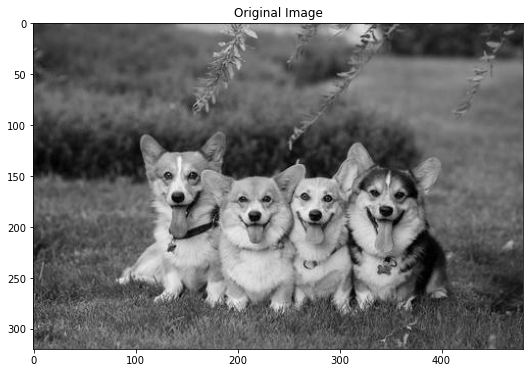

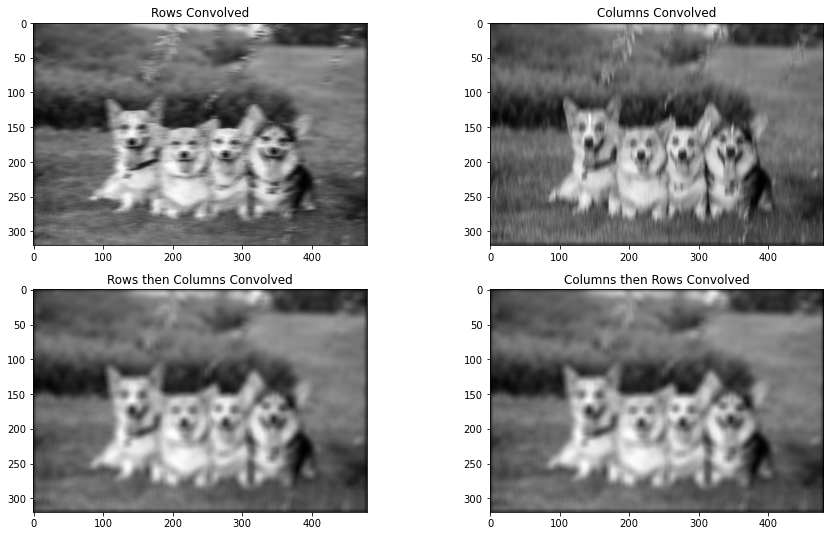

In [65]:
# make filter and load image
image = imread('test-image.jpg')
plt.figure(figsize=(10,6))
plt.imshow(image, 'gray')
plt.title('Original Image')
L = 11
h = np.ones(L) * 1/11 # impulse response of length-11 moving average filter
n_rows, n_cols = image.shape
# Code for 3.a along rows (apply filter to each row independently)
image_row = np.zeros(image.shape)
# Hint: image_row[i, :] = signal.convolve(image[i, :], h, 'same') for each row


for i in range(n_rows):
    image_row[i, :] = signal.convolve(image[i, :], h, 'same')

# along the columns (3.b)

image_col = np.zeros(image.shape)

for i in range(n_cols):
    image_col[:, i] = signal.convolve(image[:, i], h, 'same')

# rows then columns (3.c)

image_rows_cols = np.zeros(image.shape)

for i in range(n_cols):
    image_rows_cols[:, i] = signal.convolve(image_row[:, i], h, 'same')

# columns then rows (3.d)

image_cols_rows = np.zeros(image.shape)

for i in range(n_rows):
    image_cols_rows[i, :] = signal.convolve(image_col[i, :], h, 'same')


plt.figure(figsize=(15,9))
plt.subplot(221)
plt.imshow(image_row, 'gray')
plt.title('Rows Convolved')
plt.subplot(222)
plt.imshow(image_col, 'gray')
plt.title('Columns Convolved')
plt.subplot(223)
plt.imshow(image_rows_cols, 'gray')
plt.title('Rows then Columns Convolved')
plt.subplot(224)
plt.imshow(image_cols_rows, 'gray')
plt.title('Columns then Rows Convolved')


## Comments here

Part 3(e):

They appear to remain the same regardless of the order in which they are convolved. I think that this is due to the fact that we are doing them seperateley and adding them together in a sense where it acts similar to order of opertations where 8x2x4 == 4x2x8

# Exercise 4: Building an Edge Detector

Let's now apply image convolution to perform edge detection. We will build a simple edge detector step-by-step using the following simple 1D filter:

$$
h[n] = \delta[n] - \delta[n-1]
$$

a. Intuitively or mathematically, what does this filter do to an input signal? In other words, what parts of a signal would give a strong (large magnitude) response and what parts would give a weak (small magnitude) response? You may answer this with a couple signal examples and the result of convolution with $h[n]$ or qualitative intuition.

b. Is this filter causal? Why or why not? In general, is it a problem if an image filter is non-causal? (Hint: consider the contexts in which we can or cannot violate causality.)

**Note**: For the next two parts, please store your results in separate variables. This will make part (e) much cleaner.

c. Apply $h[n]$ along the rows of the ``test-image.jpg`` image. Plot the result with a grayscale color mapping.

d. Apply $h[n]$ along the columns of the ``test-image.jpg`` image. Plot the result with a grascale color mapping.

So far we have checked for edge-like features in the image going along the rows and columns. Imagine these two results as indicating edge strength along the row axis (vertical edges) and column axis (horizontal edges) of the image, respectively. Take a minute to look at the differences between these two resulting images. Can you tell which one is detecting edges within a row and which one is doing so within a column? What would be a sensible way to incorporate these two dimensions of information? Imagine they form a 2D vector and take the norm! More precisely:

$$
I_F(r,c) = \sqrt{\left(I_R(r,c)\right)^2 + \left(I_C(r,c)\right)^2},
$$

where $I_R$ and $I_C$ are the row and column filtered results from parts (c) and (d) above, respectively.

e. Build the final result image $I_F$ according to the above equation. Plot the result again with a grayscale color mapping.

## Comments here

Part 4(a):

Intuitively, this filter will detect changes or transitions in the signal. For a signal that is constant or slowly varying, the difference between adjacent samples will be small, and the convolution result will be close to zero, indicating a weak response. However, for sharp transitions or edges in the signal, the difference between adjacent samples will be large, resulting in a strong response from the convolution.

Part 4(b):

This filter is causal as it only relies on past and present values

Text(0.5, 1.0, 'Final Image')

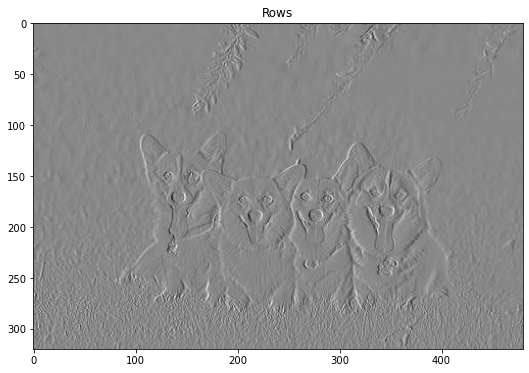

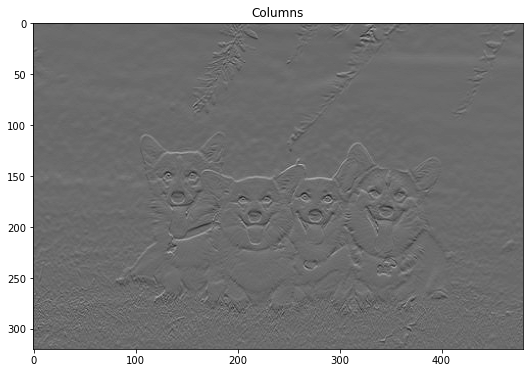

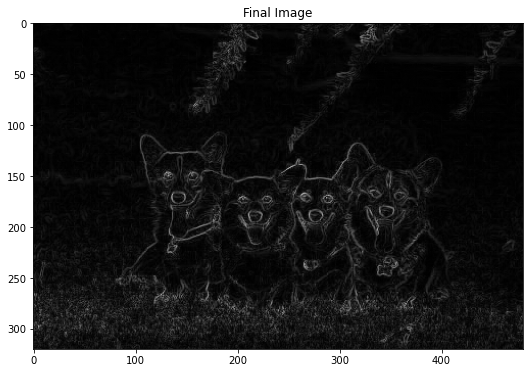

In [54]:
# load test-image.jpg
test = imread('test-image.jpg')

# Code for 4.c here:

h = np.array([1,-1])

test_rows = np.zeros(test.shape)

trows,tcols = test.shape

for i in range(trows):
    test_rows[i,:] = signal.convolve(test[i,:], h , 'same')

plt.figure(figsize=(10,6))
plt.imshow(test_rows, 'gray')
plt.title('Rows')


# Code for 4.d here:

test_cols = np.zeros(test.shape)

for i in range(tcols):
    test_cols[:,i] = signal.convolve(test[:,i],h,'same')


plt.figure(figsize=(10,6))
plt.imshow(test_cols, 'gray')
plt.title('Columns')


# Code for 4.e here:

Final_image = np.zeros(test.shape)

#for j in range(trows):
    #for k in range(tcols):
     #   test_rows[j:k] = (test_rows[j:k])**2

Final_image = np.sqrt(test_rows**2 + test_cols**2)

plt.figure(figsize=(10,6))
plt.imshow(Final_image, 'gray')
plt.title('Final Image')

## 2D Image Convolution

We don't need to limit ourselves to 1D image convolution. Our filters or "kernels" can be in two dimensions also! We will not spend much time on the math of 2D convolution/filtering in this class because it is best left for ECE 418 (Image and Video Processing); still,  we can use Python to try it out. But let's try something other than filtering this time!

Image convolution is not just for filtering or modifying an image. We can also use convolution to extract information from an image. Remember that convolution is is the process of "flipping and shifting" one signal over another signal. At each shift location, we perform a dot product (or inner product) to see how $\textit{similar}$ the signals are. A larger magnitude value at the output means the two signals are more similar. The following image illustrates 2D convolution.

<img src="convolution.jpg">

More formally, say we have a $3x3$ convolution kernel $\mathcal{K}$ where the center pixel is at index $(0,0)$, the result of the 2D convolution at pixel $(i,j)$ for image $I$, $O(i,j)$ is given by:

$$
O(i,j) = \sum_{k=-1}^{1}\sum_{l=-1}^{1}\mathcal{K}(k,l)I(i-k,j-l)
$$

Now, why is this useful? Suppose you want to design a system to recognize handwritten digits. How can you tell the difference between a "1" and a "4", for example? Think about how you as a human can separate these numbers! They both typically have one large vertical line down the middle, but we know we can differentiate them because a "4" has another shorter vertical line (depending how you draw it) and a horizontal line connecting them. This is where 2D convolution can help us! How about we create convolution kernels to highlight features we know to be discriminative, like horizontal and vertical lines.

The below code cell includes a function to perform 2D image convolution on a target image given a convolution kernel. We have also provided two 2D kernels: one for horizontal features and another for vertical features.

In [69]:
def convolve_2d(image, kernel):
    result = signal.convolve2d(image, kernel, 'same')
    result[result < 0] = 0 # Keep values non-negative
    return result

# identify horizontal lines
horiz_kernel = np.array([[-2,-2,-2,-2,-2],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [1,1,1,1,1],
                         [-2,-2,-2,-2,-2]])

# identify vertical lines
vert_kernel = np.array([[-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2],
                        [-2,1,1,1,-2]])

In the folder for this lab, we have provided example images of the numbers "1", "4", and "8" from the popular MNIST dataset. These images are 28x28 and grayscale. Let's see what our filters can identify in the ``one.jpg`` image! Note the different scales on the feature image colorbars.

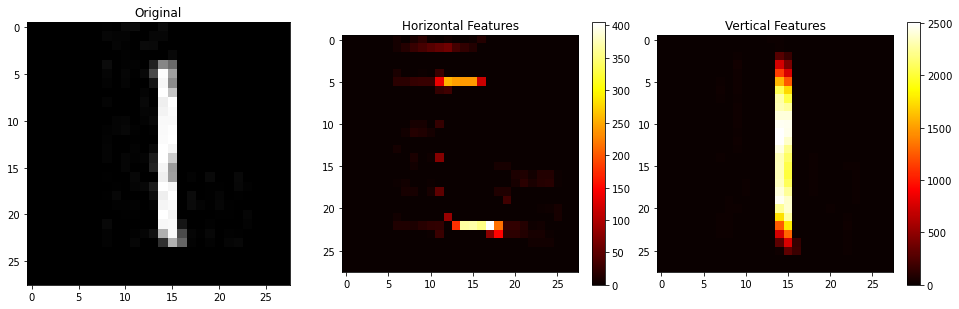

In [70]:
one = imread('one.jpg')

plt.figure(figsize=(16,10))
plt.subplot(131)
plt.title('Original')
plt.imshow(one, 'gray')

one_horiz = convolve_2d(one, horiz_kernel)
plt.subplot(132)
plt.title('Horizontal Features')
plt.imshow(one_horiz, 'hot')
plt.colorbar(fraction=0.05)

one_vert = convolve_2d(one, vert_kernel)
plt.subplot(133)
plt.title('Vertical Features')
plt.imshow(one_vert, 'hot')
plt.colorbar(fraction=0.05)

# Exercise 5: 2D Image Convolution for Feature Detection

a. Create similar plots as the above example for the "1" image for the "4" (``four.jpg``) and "8" (``eight.jpg``) images in the following code cell.

b. Comment on the results and compare what is highlighted for each number.

c. What is the significance of having negative kernel values around the positive "feature highlighting" values? Think about what would happen if the negative values were zeros instead. Try playing around with the kernels or creating your own kernel if you are unsure.


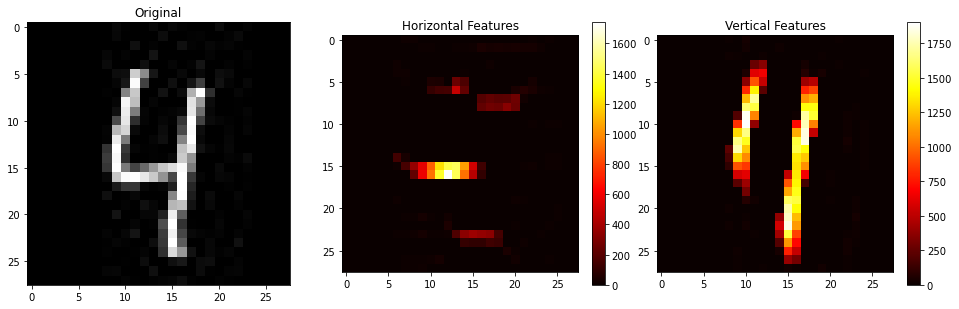

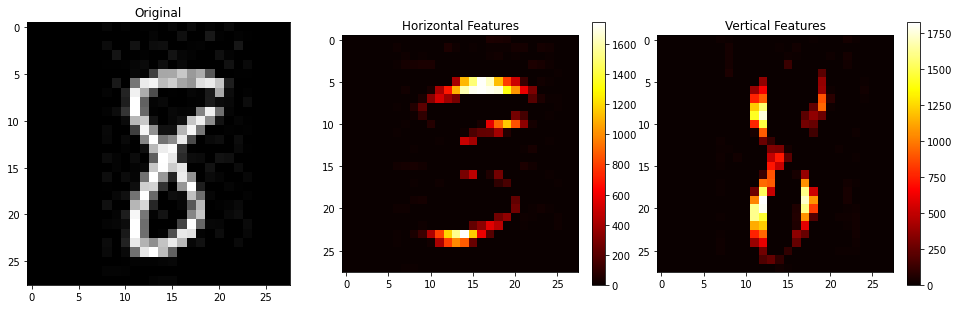

In [71]:
# Code for 5.a here

four = imread('four.jpg')

plt.figure(figsize=(16,10))
plt.subplot(131)
plt.title('Original')
plt.imshow(four, 'gray')

four_horiz = convolve_2d(four, horiz_kernel)
plt.subplot(132)
plt.title('Horizontal Features')
plt.imshow(four_horiz, 'hot')
plt.colorbar(fraction=0.05)

four_vert = convolve_2d(four, vert_kernel)
plt.subplot(133)
plt.title('Vertical Features')
plt.imshow(four_vert, 'hot')
plt.colorbar(fraction=0.05)



eight = imread('eight.jpg')

plt.figure(figsize=(16,10))
plt.subplot(131)
plt.title('Original')
plt.imshow(eight, 'gray')

eight_horiz = convolve_2d(eight, horiz_kernel)
plt.subplot(132)
plt.title('Horizontal Features')
plt.imshow(eight_horiz, 'hot')
plt.colorbar(fraction=0.05)

eight_vert = convolve_2d(eight, vert_kernel)
plt.subplot(133)
plt.title('Vertical Features')
plt.imshow(eight_vert, 'hot')
plt.colorbar(fraction=0.05)


## Comments here:

Part 5(b):

The results show the side strokes and the verticle ones giving you an idea what the number is if you put the two together. Additionally, you are able to tell the difference as ther is different seperations that occue in the numbers.

Part 5(c):

The differnce of having the negative kernals be zero begins to add it the horizontal features on the vertical feature picture. Thus giving invalid results and or not what it is that we are looking for. 

For the final activity, we will explore an example of a non-linear system. First, a bit of background.

There are many different types of noise that can appear in images. One such type is salt-and-pepper noise. This noise occurs when pixels in a camera or an existing image become fully active or inactive. In other words, a normal pixel either takes on its minimum or maximum possible value. The following code cell shows an original image and a version of it that has been corrupted by 20% salt-and-pepper noise (20% of the pixels are affected). In this activity, we will see whether we can use our LTI systems from before to denoise our image.

Text(0.5, 1.0, 'Image with 20% Salt-and-Pepper Noise')

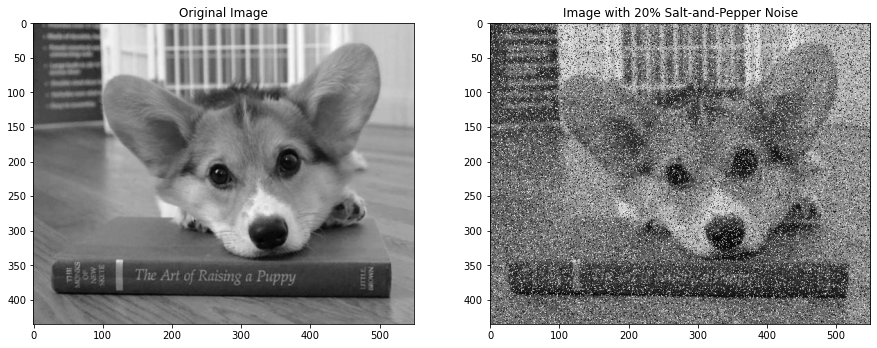

In [58]:
clean_image = imread('clean-image.jpg')
noisy_image = imread('noisy-image.jpg')
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(clean_image, 'gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(noisy_image, 'gray')
plt.title('Image with 20% Salt-and-Pepper Noise')

# Exercise 6: Non-Linear Systems are Cool Too!

We will attempt to use two different filters: a 5x5 mean filter and a 5x5 median filter. Note that a median filter is a non-linear system! A 5x5 median filter simply takes the median of the 25 pixels surrounding the center pixel in the filter and assigns that value to the center pixel.

a. Explain/prove why the median filter is a non-linear system. If you don't know where to start, try showing a counter-example for how a one-dimensional median filter fails the test for linearity. 

b. Apply a 5x5 mean filter to the noisy image and plot the result. You can do this two different ways. You can apply a length-5 mean filter along the rows and columns in any order or use our $\textrm{convolve_2d()}$ function from before with an appropriate filter you create.

c. Apply a 5x5 median filter to the noisy image and plot the result. Use $\textrm{signal.medfilt()}$ to perform the filtering. Look up the scipy documentation for notes on this function's usage.

d. Comment on the differences. Which filter seems to work better? Why do you think so?

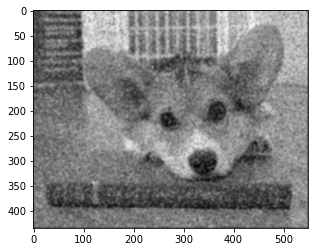

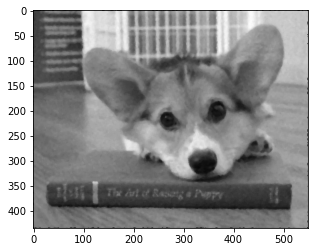

In [64]:
# Code for 6.b

rows = np.zeros(noisy_image.shape)
cols = np.zeros(noisy_image.shape)
sig = np.ones(5) * 1/5

rrows,ccols = noisy_image.shape

for i in range(rrows):
    rows[i,:] = signal.convolve(noisy_image[i,:], sig, 'same')

for i in range(ccols):
    cols[:,i] = signal.convolve(rows[:,i], sig, 'same')

plt.figure()
plt.imshow(cols, 'gray')

# Code for 6.c

median = signal.medfilt(noisy_image, 5)

plt.figure()
plt.imshow(median, 'gray')

## Comments here

Part 6(a):

The median filter is non-linear because it doesn't satisfy the properties of additivity and homogeneity. For instance, consider two 1D signals: 
x1[n]={1,0,0} and [n]={0,0,1}. The median of their sum doesn't equal the sum of their medians. This violation of additivity confirms the non-linearity of the median filter.

Part 6(d):

The one that ended up working better was the median filter. I think that this is because the system will most likely take a pixel that is right next to it and it is most likley the same or close so it will fill better. Where as the average will never be the same, but alwyas a blur created of the combination of those around it. 

## Submission Instructions

Make sure to place all image and data files along with your .ipynb lab report (this file) in one folder, zip the folder, and submit it to Canvas under the Lab 2 assignment. Please name the zip file ``<netid>_Lab2``.